In [1]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset

import numpy as np
import matplotlib.pyplot as plt
import os
import cv2
import random
import pandas as pd
import h5py
import io
from PIL import Image
import albumentations as albu
from albumentations.pytorch import ToTensorV2
from typing import Callable, List, Tuple    

In [2]:
train_meta_data = pd.read_csv("../../input/isic-2024-challenge/train-metadata.csv")
fold = pd.read_csv("../../input/isic-2024-challenge/fold.csv")
train_meta_data = train_meta_data.merge(fold, on="isic_id", how="inner")

# plt.hist(train_meta_data.groupby(by="patient_id").count().isic_id, bins=100)

/tmp/ipykernel_409931/1206565162.py:1: DtypeWarning: Columns (51,52) have mixed types. Specify dtype option on import or set low_memory=False.
  train_meta_data = pd.read_csv("../../input/isic-2024-challenge/train-metadata.csv")


In [10]:
train_meta_data.groupby(by="patient_id").count()[train_meta_data.groupby(by="patient_id").count().isic_id < 10]

,isic_id,target,age_approx,sex,anatom_site_general,clin_size_long_diam_mm,image_type,tbp_tile_type,tbp_lv_A,tbp_lv_Aext,...,iddx_full,iddx_1,iddx_2,iddx_3,iddx_4,iddx_5,mel_mitotic_index,mel_thick_mm,tbp_lv_dnn_lesion_confidence,fold_id
patient_id,,,,,,,,,,,,,,,,,,,,,
IP_0432384,8,8,8,8,0,8,8,8,8,8,...,8,8,0,0,0,0,0,0,8,8
IP_0990901,9,9,9,9,9,9,9,9,9,9,...,9,9,0,0,0,0,0,0,9,9
IP_1216329,1,1,1,1,1,1,1,1,1,1,...,1,1,0,0,0,0,0,0,1,1
IP_1487179,1,1,1,1,1,1,1,1,1,1,...,1,1,0,0,0,0,0,0,1,1
IP_1510720,2,2,2,2,2,2,2,2,2,2,...,2,2,0,0,0,0,0,0,2,2
IP_3374234,7,7,0,7,0,7,7,7,7,7,...,7,7,0,0,0,0,0,0,7,7
IP_3462387,9,9,9,9,9,9,9,9,9,9,...,9,9,0,0,0,0,0,0,9,9
IP_3621991,7,7,7,7,7,7,7,7,7,7,...,7,7,0,0,0,0,0,0,7,7
IP_3772472,3,3,3,3,3,3,3,3,3,3,...,3,3,0,0,0,0,0,0,3,3


In [12]:
def get_table_feat(meta_data: pd.DataFrame, idx:int,):
    cont_feats = [d[0] for d in meta_data.dtypes.to_dict().items() if d[1] != "object"]
    cat_feats = [d[0] for d in meta_data.dtypes.to_dict().items() if d[1] == "object"]
    
    return {
        "cont_feats": meta_data.loc[idx, cont_feats].values, 
        "cat_feats": meta_data.loc[idx, cat_feats].values
        }
get_table_feat(train_meta_data, 5)

NameError: name 'test_meta_data' is not defined

In [4]:
test_meta_data = pd.read_csv("../../input/isic-2024-challenge/test-metadata.csv")
test_meta_data

,isic_id,patient_id,age_approx,sex,anatom_site_general,clin_size_long_diam_mm,image_type,tbp_tile_type,tbp_lv_A,tbp_lv_Aext,...,tbp_lv_radial_color_std_max,tbp_lv_stdL,tbp_lv_stdLExt,tbp_lv_symm_2axis,tbp_lv_symm_2axis_angle,tbp_lv_x,tbp_lv_y,tbp_lv_z,attribution,copyright_license
0,ISIC_0015657,IP_6074337,45.0,male,posterior torso,2.70,TBP tile: close-up,3D: XP,22.80433,20.007270,...,0.304827,1.281532,2.299935,0.479339,20,-155.06510,1511.222000,113.980100,Memorial Sloan Kettering Cancer Center,CC-BY
1,ISIC_0015729,IP_1664139,35.0,female,lower extremity,2.52,TBP tile: close-up,3D: XP,16.64867,9.657964,...,0.000000,1.271940,2.011223,0.426230,25,-112.36924,629.535889,-15.019287,"Frazer Institute, The University of Queensland...",CC-BY
2,ISIC_0015740,IP_7142616,65.0,male,posterior torso,3.16,TBP tile: close-up,3D: XP,24.25384,19.937380,...,0.230742,1.080308,2.705857,0.366071,110,-84.29282,1303.978000,-28.576050,FNQH Cairns,CC-BY


In [24]:
idx = 0

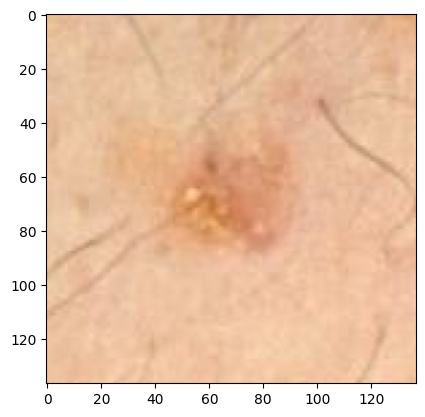

In [127]:
train_images = h5py.File("../../input/isic-2024-challenge/train-image.hdf5", "r")
plt.imshow(np.array(Image.open(io.BytesIO(np.array(train_images[list(train_images.keys())[idx]]))),dtype=np.uint8))
idx += 1

In [6]:
def get_transforms(train: bool = False, image_size: int = 256) -> Callable:
    if train:
        return albu.Compose(
            [
                albu.Resize(image_size, image_size),
                albu.Transpose(p=0.5),
                albu.VerticalFlip(p=0.5),
                albu.HorizontalFlip(p=0.5),
                albu.RandomBrightnessContrast(brightness_limit=0.2, contrast_limit=0.2, p=0.75),
                albu.OneOf([
                    albu.MotionBlur(blur_limit=5),
                    albu.MedianBlur(blur_limit=5),
                    albu.GaussianBlur(blur_limit=5),
                    albu.GaussNoise(var_limit=(5.0, 30.0)),
                ], p=0.7),
                albu.OneOf([
                    albu.OpticalDistortion(distort_limit=1.0),
                    albu.GridDistortion(num_steps=5, distort_limit=1.),
                    albu.ElasticTransform(alpha=3),
                ], p=0.7),
                albu.CLAHE(clip_limit=4.0, p=0.7),
                albu.HueSaturationValue(hue_shift_limit=10, sat_shift_limit=20, val_shift_limit=10, p=0.5),
                albu.ShiftScaleRotate(shift_limit=0.1, scale_limit=0.1, rotate_limit=15, border_mode=0, p=0.85),
                albu.CoarseDropout(max_height=int(image_size * 0.375), max_width=int(image_size * 0.375), max_holes=1, p=0.7),
                ToTensorV2(),
            ]
        )
    else:
        return albu.Compose(
            [
                albu.Resize(image_size, image_size),
                ToTensorV2(),
            ]
        )

In [7]:
def load_image(image_id: str, data: h5py.File) -> np.ndarray:
    return np.array(Image.open(io.BytesIO(np.array(data[image_id]))))

class ISICDataset(Dataset):
    def __init__(self, meta_data: pd.DataFrame, data: h5py.File, mode="train"):
        self.meta_data = meta_data
        self.data = data
        self.transforms = get_transforms(train= mode == "train")
        
    def __len__(self) -> int:
        return len(self.meta_data)
    
    def __getitem__(self, idx: int) -> Tuple[torch.Tensor, torch.Tensor]:
        image_id = self.meta_data.iloc[idx].isic_id
        image = load_image(image_id, self.data)
        image = self.transforms(image=image)["image"]
        return image

In [10]:
dataset = ISICDataset(train_meta_data, train_images, mode="train")

In [11]:
idx = 0

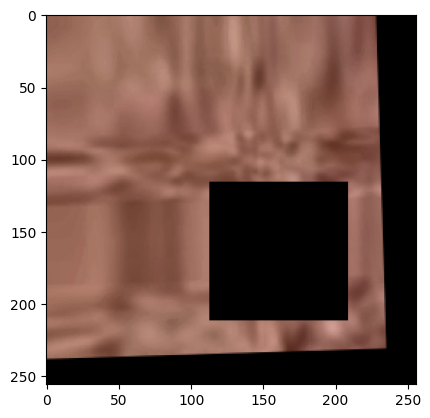

In [17]:
plt.imshow(dataset[idx].permute(1, 2, 0))
idx += 1